Loading the dataset
At the moment we need to load the annotations directly from the database. We can replace this code with loading the csv file once the challenge is released

In [3]:
import numpy as np
import pandas as pd
from hcai_datasets.hcai_nova_dynamic.nova_db_handler import NovaDBHandler
from matplotlib.backends.backend_pdf import PdfPages

# Database Config file
db_cfg_path = '../../.configs/nova/nova_db.cfg'

# Sets
sessions_test = [f'recording{i:02d}' for i in range(1,7)]
sessions_train = [f'recording{i:02d}' for i in range(7,29)]

# Annotators
annotators = ['liechtensteinaugust','reineckermarcleon', 'fabianmaurer']

# Roles
roles = ['subjectPos1', 'subjectPos2', 'subjectPos3', 'subjectPos4']

# Schemes
scheme_consensus = 'backchannel_consensuality'
scheme_nonverbal = 'backchannel_nonverbal'
scheme_paraverbal = 'backchannel_paraverbal'
scheme_verbal = 'backchannel_verbal'

# Database handler
db_handler = NovaDBHandler(db_cfg_path)

# Annos
consensus = {}
nonverbal = {}
paraverbal = {}
verbal = {}


# Loading
for s in sessions_train + sessions_test:
    for r in roles:
        for a in annotators:
            print(f'Loading anno {s} - {r} - {a}')
            consensus[(s, r, a)] = db_handler.get_annos(dataset='mpiiemo', scheme=scheme_consensus, session=s,annotator=a,roles=r)
            nonverbal[(s, r, a)] = db_handler.get_annos(dataset='mpiiemo', scheme=scheme_nonverbal, session=s,annotator=a,roles=r)
            paraverbal[(s, r, a)] = db_handler.get_annos(dataset='mpiiemo', scheme=scheme_paraverbal, session=s,annotator=a,roles=r)
            verbal[(s, r, a)] = db_handler.get_annos(dataset='mpiiemo', scheme=scheme_verbal, session=s,annotator=a,roles=r)

Loaded config from ../../.configs/nova/nova_db.cfg:
---------------------
DB
	ip : 137.250.171.233
	port : 37317
	user : schildom
---------------------
Loading anno recording07 - subjectPos1 - liechtensteinaugust
No annotions found for 
	-annotator: liechtensteinaugust
	-scheme: backchannel_consensuality
	-session: recording07
	-role: subjectPos1
No annotions found for 
	-annotator: liechtensteinaugust
	-scheme: backchannel_nonverbal
	-session: recording07
	-role: subjectPos1
No annotions found for 
	-annotator: liechtensteinaugust
	-scheme: backchannel_paraverbal
	-session: recording07
	-role: subjectPos1
No annotions found for 
	-annotator: liechtensteinaugust
	-scheme: backchannel_verbal
	-session: recording07
	-role: subjectPos1
Loading anno recording07 - subjectPos1 - reineckermarcleon
No annotions found for 
	-annotator: reineckermarcleon
	-scheme: backchannel_consensuality
	-session: recording07
	-role: subjectPos1
No annotions found for 
	-annotator: reineckermarcleon
	-scheme:

In [217]:
# 0: consensus, 1: nonverbal, 2: paraverbal, 3: verbal
data_header = ['consensus', 'nonverbal', 'paraverbal', 'verbal']

# Dropping empty annos and convert rest to pandas dataframes
annos = [
    {key:pd.DataFrame(val) for key, val in consensus.items() if val != -1},
    {key:pd.DataFrame(val) for key, val in nonverbal.items() if val != -1},
    {key:pd.DataFrame(val) for key, val in paraverbal.items() if val != -1},
    {key:pd.DataFrame(val) for key, val in verbal.items() if val != -1}
]

# Add Partition to index
annos = [ {(('Train+Val',)+key if key[0] in sessions_train else ('Test',) + key) : val for key, val in x.items() } for x in annos]

In [218]:
def df_for_scheme(annos):
    df = pd.concat(annos)
    df = df.drop(columns=['conf', 'meta'])
    df.index.names = ['set', 'session', 'subject', 'annotator', 'id']
    df['dur'] = df['to'] - df['from']
    df = df.rename(columns={'id':'label'})
    return df

annos_stats = {n : df_for_scheme(annos[i]) for i,n in enumerate(data_header)}

# Map consensus label id to float value
annos_stats['consensus']['label'] = annos_stats['consensus']['label'].astype(float).replace(
    [0,1,2,3,4,5,6,7,8,9],
    [-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,np.nan]
)

print(annos_stats)
print('Annos have been generated. Read for analysis')

{'consensus':                                                              from       to  \
set       session     subject     annotator           id                     
Train+Val recording07 subjectPos2 liechtensteinaugust 0     22.60    23.16   
                                                      1     23.76    25.04   
                                                      2     28.52    30.36   
                                                      3     32.64    33.64   
                                                      4     92.12    93.08   
...                                                           ...      ...   
Test      recording02 subjectPos2 fabianmaurer        63  1113.52  1117.04   
                                                      64  1138.88  1140.16   
                                                      65  1140.36  1140.72   
                                                      66  1170.96  1171.92   
                                                  

Let`s generate some statistics...
We start with the general description of the dataframes

In [219]:
for k,v in annos_stats.items():
    print('----------------')
    print(v.describe())

----------------
              from           to        label          dur
count  6039.000000  6039.000000  5969.000000  6039.000000
mean    584.105859   585.792416     0.289873     1.686557
std     350.037287   350.114822     0.411309     1.578418
min       0.200000     1.600000    -1.000000     0.000000
25%     272.840000   273.960000     0.000000     0.800000
50%     580.720000   582.520000     0.250000     1.280000
75%     879.340000   881.360000     0.500000     2.000000
max    1301.440000  1301.880000     1.000000    25.080000
----------------
              from           to   label          dur
count  4328.000000  4328.000000  4328.0  4328.000000
mean    592.173013   594.015102     0.0     1.842089
std     353.044153   353.127587     0.0     1.506278
min       0.200000     1.640000     0.0     0.000000
25%     282.670000   284.320000     0.0     0.960000
50%     585.700000   587.100000     0.0     1.440000
75%     901.300000   903.540000     0.0     2.200000
max    1301.440000  

## Backchannel Modalities ##

Generate statistics for backchannel modalities. First we plot the label count and the average duration per session per annotation track.
Also we plot a combination of verbal and paraverbal backchannels since those might not be clearly differentiated by the annotators.

In [224]:
from matplotlib import pyplot as plt

def plot_dist_for_modality_schemes(schemes, partition, title='', file_name=None,  font_size = 20):
    '''Plot Dtaframe statistics
    :param scheme: List of annotation schemes to plot
    :param partition: Test or Train
    :param stat: The column with the data t o plot
    :param title: Optional title for the plot
    :param file_name: Optional filename to save the plot under
    :param font_size: Optional font size to use in the plot
    '''

    # create new dataframe
    df_plot_label = pd.DataFrame()
    df_plot_duration = pd.DataFrame()

    for scheme in schemes:
        df_filtered = annos_stats[scheme].loc[partition,:,:,:]
        df_grouped = df_filtered.droplevel('id').groupby(level=['session'])
        stats = df_grouped.describe()
        df_plot_label[scheme] = stats['label']['count']
        df_plot_duration[scheme] = stats['dur']['mean']

    # plotting
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,15))
    df_plot_label.rename(lambda x : x[-2:]).plot(kind='bar', ax=axes[0], fontsize=font_size, xlabel='')
    df_plot_duration.rename(lambda x : x[-2:]).plot(kind='bar', ax=axes[1], fontsize=font_size, xlabel='')

    axes[0].set_title(f'Label Count {title if title is not None else scheme}- {partition}' ,fontweight="bold", size=font_size)
    axes[1].set_title(f'Average Duration {title if title is not None else scheme}- {partition}' ,fontweight="bold", size=font_size)
    axes[1].set_xlabel('Session', fontsize=font_size)
    axes[0].set_ylabel('Count', fontsize=font_size)
    axes[1].set_ylabel('Duration', fontsize=font_size)
    axes[0].legend(prop = {'size' : 25}, bbox_to_anchor=(1, 1.03), loc='upper left')
    axes[1].get_legend().remove()
    plt.tight_layout()
    plt.subplots_adjust(left=0.125,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.35)


    # save as pdf
    if file_name:
        with PdfPages(file_name + '.pdf') as pdf:
            pdf.savefig(bbox_inches='tight')

    plt.show()

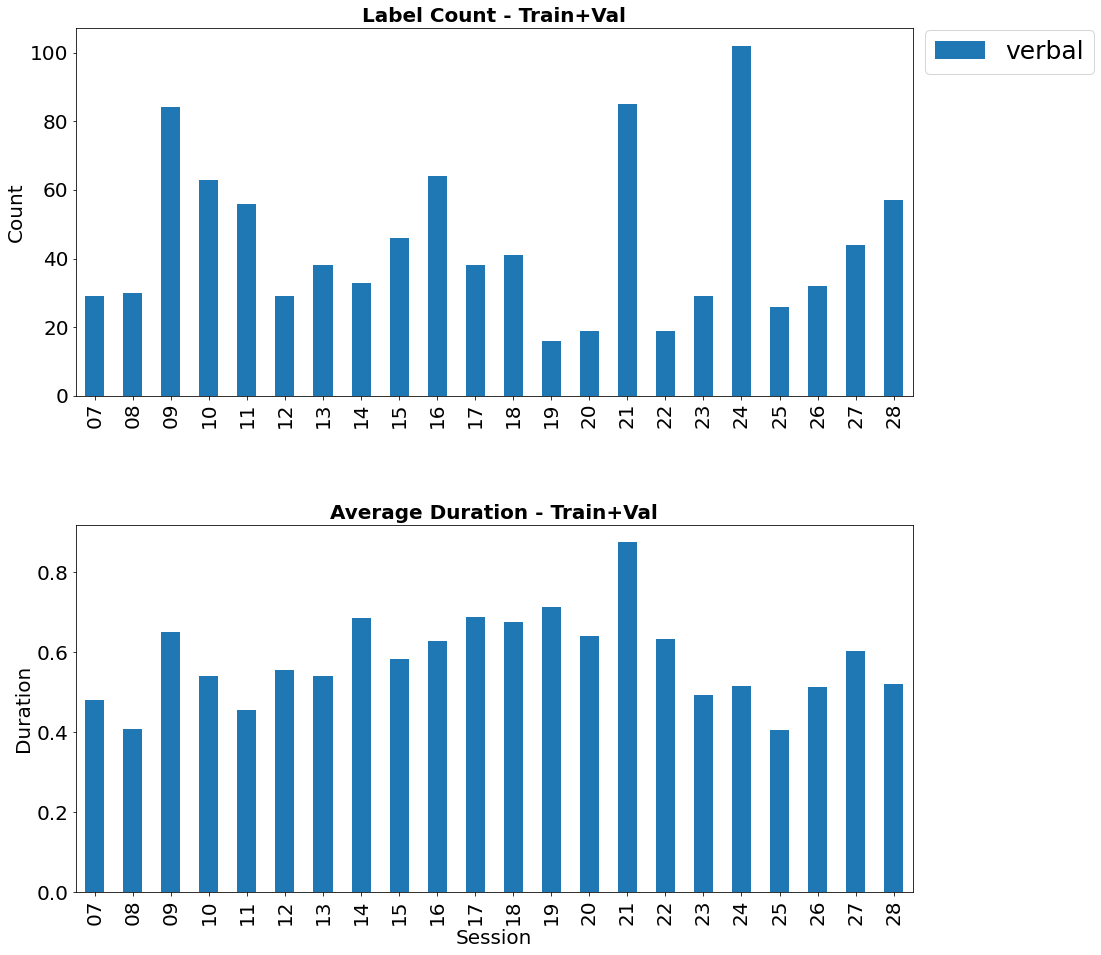

In [225]:
plot_dist_for_modality_schemes(['verbal'], 'Train+Val')

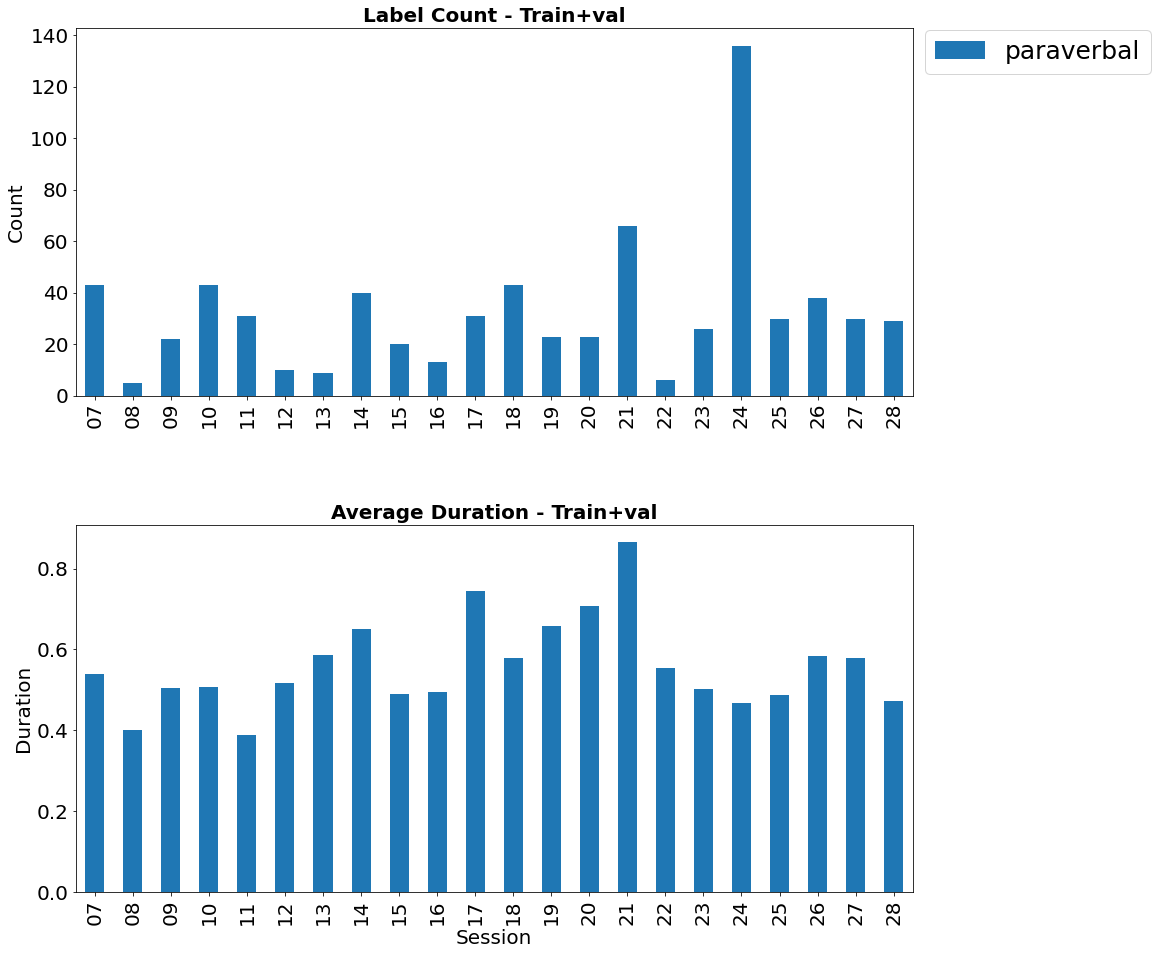

In [223]:
plot_dist_for_modality_schemes(['paraverbal'], 'Train+Val')

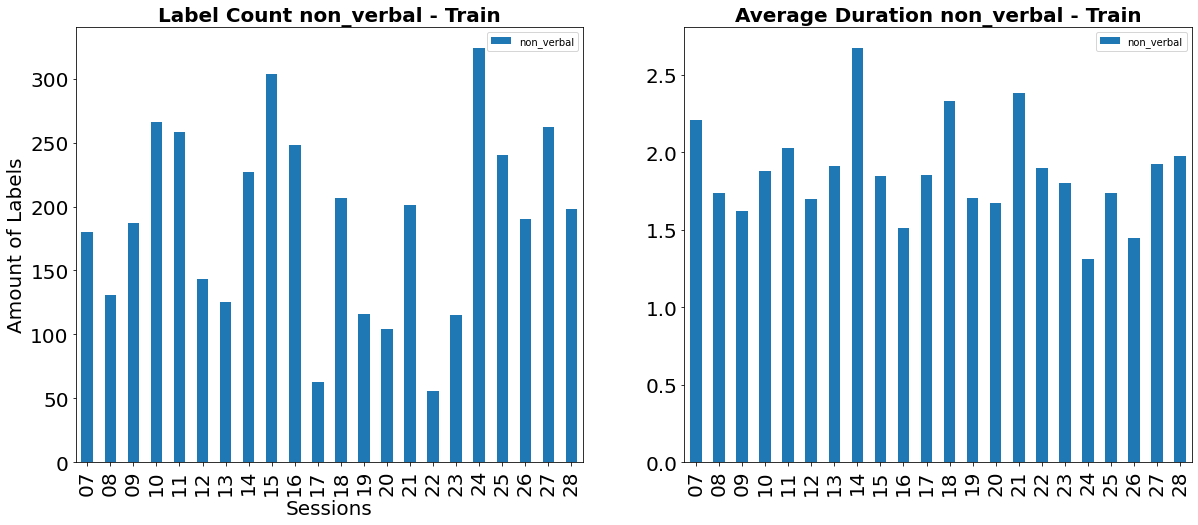

In [44]:
plot_dist_for_modality_schemes(['nonverbal'], 'Train+Val')

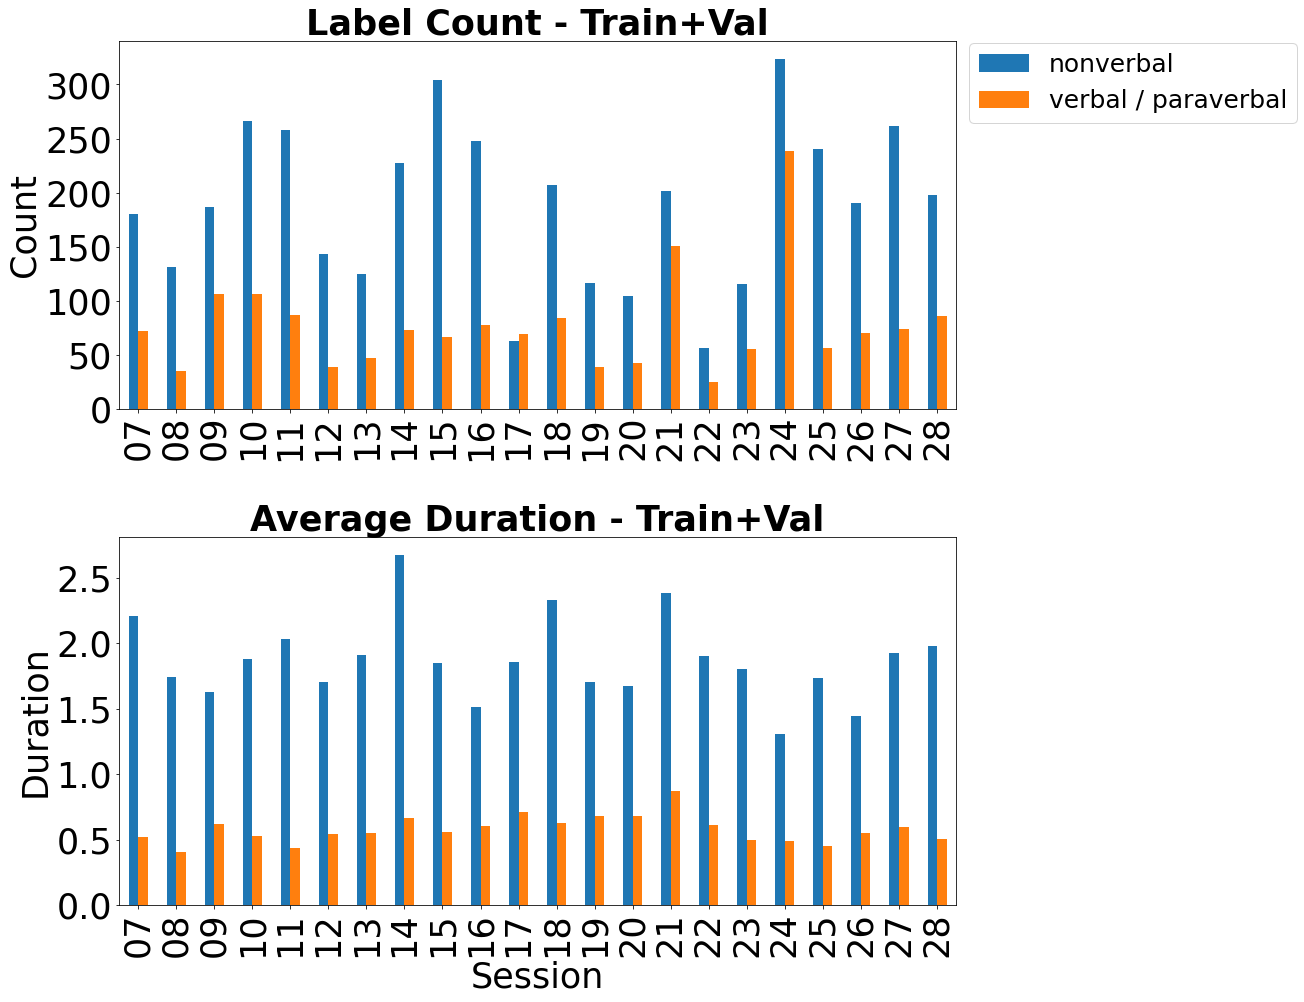

In [226]:
# combine nonverbal stats
annos_stats['verbal / paraverbal'] = pd.concat([annos_stats['paraverbal'], annos_stats['verbal']])
plot_dist_for_modality_schemes(['nonverbal', 'verbal / paraverbal'], 'Train+Val', title='', file_name='bc_stats', font_size=35)

## Backchannel Consensuality
In the following we first generate an overeview of the data

In [66]:
# Generate Stats for Train+Val
df_train = annos_stats['consensus'].loc['Train+Val',:,:,:]
df_train.droplevel('id').drop(columns=['from', 'to']).groupby(level=['session']).describe()

label                                                       dur  \
             count      mean       std   min     25%   50%   75%  max  count   
session                                                                        
recording07  538.0  0.237454  0.354481 -1.00  0.0625  0.25  0.50  1.0  539.0   
recording08  428.0  0.162967  0.256396 -0.75  0.0000  0.00  0.25  1.0  440.0   
recording09  252.0  0.252976  0.263559 -1.00  0.0000  0.25  0.50  1.0  252.0   
recording10  629.0  0.201510  0.359740 -1.00  0.0000  0.25  0.25  1.0  632.0   
recording11  559.0  0.238372  0.333466 -1.00  0.2500  0.25  0.50  1.0  562.0   
recording12  157.0  0.272293  0.507457 -1.00  0.0000  0.25  0.75  1.0  158.0   
recording13  139.0  0.073741  0.600764 -1.00 -0.2500  0.25  0.50  1.0  140.0   
recording14  127.0  0.415354  0.425176 -1.00  0.2500  0.50  0.75  1.0  127.0   
recording15  320.0  0.314844  0.335197 -1.00  0.2500  0.25  0.50  1.0  322.0   
recording16  269.0  0.333643  0.425923 -1.00  0.2500  0.25  0.50  1.0  271.0   
recording17  106.0  0.268868  0.429144 -1.00  0.0000  0.25  0.50  1.0  107.0   
recording18  230.0  0.280435  0.198652 -0.50  0.2500  0.25  0.25  1.0  230.0   
recording19  128.0  0.378906  0.364498 -1.00  0.2500  0.25  0.50  1.0  128.0   
recording20   92.0  0.228261  0.364368 -1.00  0.2500  0.25  0.50  1.0   92.0   
recording21  271.0  0.343173  0.468784 -1.00  0.2500  0.50  0.50  1.0  272.0   
recording22   64.0  0.441406  0.317299  0.00  0.2500  0.25  0.50  1.0   64.0   
recording23  142.0  0.533451  0.396381 -0.25  0.2500  0.50  1.00  1.0  142.0   
recording24  273.0  0.483516  0.384324 -0.50  0.2500  0.50  1.00  1.0  273.0   
recording25  146.0  0.227740  0.359503 -1.00  0.0000  0.25  0.50  1.0  146.0   
recording26  217.0  0.099078  0.493569 -1.00 -0.2500  0.25  0.25  1.0  218.0   
recording27  281.0  0.502669  0.574955 -1.00  0.2500  0.75  1.00  1.0  282.0   
recording28  228.0  0.403509  0.634896 -1.00  0.2500  0.50  1.00  1.0  228.0   

                                                                
                 mean       std   min   25%   50%   75%    max  
session                                                         
recording07  1.908423  2.001416  0.00  0.92  1.28  2.24  20.56  
recording08  1.618091  1.945260  0.16  0.68  1.00  1.76  15.36  
recording09  1.414603  1.268601  0.20  0.72  1.12  1.68  12.68  
recording10  1.682278  1.417183  0.28  0.87  1.32  2.08  13.24  
recording11  1.903915  2.197773  0.16  0.88  1.40  1.96  25.08  
recording12  1.609367  1.313077  0.24  0.80  1.20  1.90   8.32  
recording13  1.770857  1.395399  0.24  0.88  1.36  2.17   8.84  
recording14  3.066142  2.206877  0.40  1.60  2.32  4.18  10.72  
recording15  1.788820  1.191247  0.20  1.08  1.52  2.16  12.48  
recording16  1.462878  1.132455  0.24  0.84  1.20  1.64  10.04  
recording17  1.420935  1.301649  0.32  0.68  1.08  1.58  10.08  
recording18  2.174435  1.686353  0.40  1.13  1.60  2.79  12.84  
recording19  1.616563  0.901520  0.40  1.00  1.44  2.00   6.28  
recording20  1.521739  0.872474  0.40  0.80  1.32  1.98   4.16  
recording21  2.029559  1.589260  0.48  1.04  1.54  2.57  14.20  
recording22  1.781250  1.464223  0.48  0.80  1.28  2.54   8.84  
recording23  1.566197  1.066006  0.20  0.89  1.28  2.01   5.84  
recording24  1.022711  0.846922  0.20  0.56  0.80  1.20   6.96  
recording25  1.764110  1.369998  0.20  0.97  1.40  2.04   8.28  
recording26  1.349541  1.088491  0.28  0.69  1.08  1.59   8.88  
recording27  1.846950  1.193559  0.28  0.92  1.60  2.43   6.76  
recording28  1.811754  1.450693  0.16  0.80  1.40  2.41   9.20

In [ ]:
# Generate Stats for test
df_test = annos_stats['consensus'].loc['Test',:,:,:]
df_test.droplevel('id').drop(columns=['from', 'to']).groupby(level=['session']).describe()

To display the distribution of the consensuality labels we use a histogram plot.
Preliminarily we also rely on the annotations from August to create the plot since we do not have all annotations yet

 0.25    1518
 0.50     692
 1.00     682
-0.25     362
 0.00     361
 0.75     195
-0.50     174
-1.00      95
-0.75      49
Name: label, dtype: int64


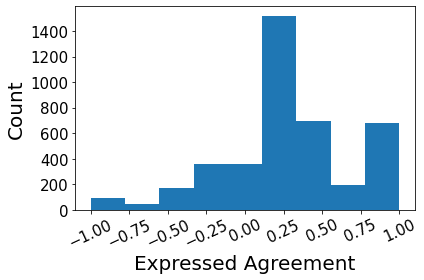

In [216]:
#plot
df_train_august = df_train.loc[:,:,'liechtensteinaugust']
print(df_train_august['label'].value_counts())
axes = df_train_august['label'].plot.hist(bins=9)# title='Agreement expressed by Backchannel - Train')

plt.xticks(fontsize=15, rotation=25)
plt.yticks(fontsize=15, rotation=0)
plt.xlabel('Expressed Agreement', fontsize=20)
plt.ylabel('Count', fontsize=20)

 # fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,20))
 #    df_plot_label.rename(lambda x : x[-2:]).plot(kind='bar', ax=axes[0], fontsize=font_size, xlabel='')
 #    df_plot_duration.rename(lambda x : x[-2:]).plot(kind='bar', ax=axes[1], fontsize=font_size, xlabel='')
 #
 #    axes[0].set_title(f'Label Count {title if title is not None else scheme}- {partition.capitalize()}' ,fontweight="bold", size=font_size)
 #    axes[1].set_title(f'Average Duration {title if title is not None else scheme}- {partition.capitalize()}' ,fontweight="bold", size=font_size)
 #    axes[1].set_xlabel('Session', fontsize=font_size)
 #    axes[0].set_ylabel('Amount of Labels', fontsize=font_size)
 #    axes[1].set_ylabel('Duration in Seconds', fontsize=font_size)
 #    axes[0].legend(prop = {'size' : 25})
 #    axes[1].legend(prop = {'size' : 25})

# save as pdf
plt.tight_layout()
with PdfPages('bc_agreement_stats.pdf') as pdf:
    pdf.savefig()
plt.show()

Plotting the statistics for backchannel consensuality


In [67]:
tmp = df_train.groupby(level=['session', 'subject', 'id'])
for key, item in tmp:
    print(tmp.get_group(key), "\n\n")
#tmp['id'].aggregate('')


                                                from     to  label   dur
session     subject     annotator           id                          
recording07 subjectPos2 liechtensteinaugust 0   22.6  23.16   0.25  0.56
                        reineckermarcleon   0   22.6  23.16   0.00  0.56
                        fabianmaurer        0   22.6  23.16   0.25  0.56 


                                                 from     to  label   dur
session     subject     annotator           id                           
recording07 subjectPos2 liechtensteinaugust 1   23.76  25.04    1.0  1.28
                        reineckermarcleon   1   23.76  25.04    0.0  1.28
                        fabianmaurer        1   23.76  25.04    0.5  1.28 


                                                 from     to  label   dur
session     subject     annotator           id                           
recording07 subjectPos2 liechtensteinaugust 2   28.52  30.36   0.00  1.84
                        reineckermarc